In [1]:
from brainpipe.system import study
import numpy as np
from itertools import product
from os.path import join, exists
from os import makedirs
from scipy import stats
from mne.stats import fdr_correction, bonferroni_correction
from joblib import Parallel, delayed
import pandas as pd
import pingouin as pg

In [139]:
"""
Compute differences of tps wth and btw for all elecs and odors
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/')
tps_btw = join(path_npz, 'TPS_spear_{}_odor{}_btw_{}.npz')
tps_wth = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
tps_save= join(path_npz, 'TPS_spear_{}_odor{}_{}_diff_wth_btw.npz')
###############################################################################
exp = 'Ret' #Ret, Enc
freqs = ['0_theta', '1_alpha', '2_beta','3_gamma']
conds = ['high','low']
odors_su = {'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
}

def tpsim_diff_by_od(exp,su,freq):
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        else:
            mat = np.load(tps_btw.format(exp,su,od,freq[2:]),allow_pickle=True)
            btw = mat['tps']
            wth = np.load(tps_wth.format(exp,su,od,freq[:]))['tps']
            print(su,od,btw.shape,wth.shape)
            diff = np.array([])
            for t0, t1 in product(range(btw.shape[-1]),range(wth.shape[-1])):
                d = wth[:,t1] - btw[:,t0]
                diff = np.concatenate((diff,d[:,np.newaxis]),axis=-1) \
                                                if np.size(diff) else d[:,np.newaxis]
            print(freq,su,od,diff.shape)
            dico = {'tps_diff':diff, 'label':mat['label'],
                   'channel':mat['channel'], 'xyz':mat['xyz']}
            np.savez(tps_save.format(exp,su,od,freq[2:]),**dico)
            del dico, diff,mat, btw, wth
            

for su, freq in product(odors_su,freqs):
    tpsim_diff_by_od(exp,su,freq)
#Parallel(n_jobs=-1)(delayed(
#         tpsim_diff_by_od)(exp,su,freq) for su,freq in product(odors_su,freqs))

-> Olfacto loaded


FileNotFoundError: [Errno 2] No such file or directory: '/media/karim/Datas4To/1_Analyses_Intra_EM_Odor/Olfacto/feature/TPSim_Ret_By_Odor_By_Cond/TPS_by_odor/TPS_spear_CHAF_odor_5_0_theta.npz'

In [158]:
"""
Compute differences of tps wth and btw for all elecs and odors
1- ANOVA F-test for a significant effect of ODORS (bonferonni corrected)
2- T-tests btw all odors when F sig 
3- Count electrodes and ROI where F and all T are significant
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/')
tps_name = join(path_npz, 'TPS_spear_{}_odor{}_{}_diff_wth_btw.npz')
#tps_name = join(path_npz, 'TPS_spear_{}_odor{}_btw_{}.npz')
###############################################################################
from scipy.special import comb
from collections import Counter
exp = 'Ret' #Ret, Enc
freqs = ['0_theta','2_beta'] #1_alpha, 3_gamma
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 10
conds = ['high','low']
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
            }

labels_theta, labels_beta = [], []
for su, freq in product(odors_su,freqs):
    all_odors_diff, odors_list = [], []
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            mat = np.load(tps_name.format(exp,su,od,freq[2:]),allow_pickle=True)
            tps_d = mat['tps_diff']
            #print(su,od, tps_d.shape)
            nelecs, ntrials = tps_d.shape
            all_odors_diff.append(tps_d)
            od_list = [od]*ntrials
            odors_list.append(od_list)
    
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    odors_list = np.concatenate(odors_list,axis=0)
    all_F, all_p = [], []
    channels_sig, labels_sig = [], []
    for elec in range(nelecs):
        #UPDATE ROIs LABELS
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        elec_diff = np.concatenate([x[elec] for x in all_odors_diff])
        #print(elec_diff.shape, len(odors_list))
        df = pd.DataFrame({'odors':np.array(odors_list),'tps_diff':elec_diff})
        df_odors = df.groupby(['odors']).mean()
        df_sig = df_odors.loc[df_odors['tps_diff']>0]
        if len(df_sig) == len(all_odors_diff):
            aov = pg.welch_anova(data=df, dv='tps_diff', between='odors')
            all_F.append(aov['F'].values[0])
            all_p.append(aov['p-unc'].values[0])
            if aov['p-unc'].values[0] < (0.05/nelecs) : #and lab == 'OFC_olf':
    #                 print(su,freq,channels[elec],labels[elec])
                t_stats = pg.pairwise_tukey(data=df,dv='tps_diff',between='odors')
                #print(su,elec, lab,'sig')
                #print(t_stats)
                p_t = t_stats['p-tukey'].values
                bool_t = [1 for p in p_t if p <0.05]
                n_comb = comb(len(all_odors_diff),2)
                if sum(bool_t) == n_comb if su in ['CHAF','PIRJ'] else sum(bool_t) >= n_comb/2 :
                    channels_sig.append(channels[elec])
                    labels_sig.append(lab)
    #                     print('for %s in %s for elec %s in %s' %(su,freq[2:],channels[elec],labels[elec]),
    #                     '\n >>> ANOVA, F:', aov['F'].values[0],'pF unc', aov['p-unc'].values[0],
    #                     '\n >>> T-tests max abs:',max(abs(t_stats['T'].values)),'p',max(p_t),'\n')
    if len(labels_sig) > 0 :
        labels_theta.append(labels_sig) if freq == freqs[0] \
                else labels_beta.append(labels_sig)
print(labels_theta, labels_beta)

#SUM UP RESULTS
#if len(labels_theta) > 0:
lab_unique = [np.unique(x) for x in labels_theta]
labels_theta = np.concatenate([x for x in lab_unique])
count_theta = Counter(labels_theta)
print('Counter Theta',count_theta)
#if len(labels_beta) > 0:
lab_unique = [np.unique(x) for x in labels_beta]
labels_beta = np.concatenate([x for x in lab_unique])
count_beta = Counter(np.array(labels_beta))
print('Counter Beta', count_beta)

-> Olfacto loaded
[['Amg-PirT', 'Ins', 'aHC', 'aHC', 'aHC', 'aHC', 'aHC', 'MFG', 'MFG', 'ACC', 'ACC', 'OFC', 'OFC_olf', 'OFC_olf', 'OFC', 'SFG', 'SFG'], ['aHC', 'aHC', 'aHC', 'Amg', 'Amg', 'Amg', 'IFG', 'IFG', 'IFG', 'IFG', 'ACC', 'MFG', 'MFG', 'OFC_olf', 'OFC_olf', 'OFC_olf', 'IFG', 'OFC', 'OFC', 'OFC'], ['aHC', 'aHC', 'aHC', 'Ins', 'IFG', 'OFC', 'OFC', 'OFC', 'MFG', 'IFG', 'IFG', 'MFG', 'MFG', 'IFG', 'IFG', 'IFG', 'OFC_olf', 'OFC_olf', 'OFC_olf', 'OFC', 'IFG', 'IFG', 'MFG', 'MFG', 'ACC', 'SFG', 'SFG', 'SFG'], ['aHC', 'aHC', 'aHC', 'PHG', 'PHG', 'PHG', 'PHG', 'PHG', 'HC', 'Ins', 'Ins', 'pPirT', 'PHG', 'PHG', 'OFC', 'IFG', 'IFG', 'Ins']] [['Ins', 'Ins', 'aHC', 'aHC', 'aHC', 'MFG', 'MFG', 'MFG', 'IFG', 'OFC', 'OFC_olf', 'OFC_olf', 'OFC_olf', 'OFC_olf', 'OFC_olf', 'OFC', 'SFG', 'SFG'], ['aHC', 'aHC', 'aHC', 'aHC', 'Amg', 'Amg', 'IFG', 'IFG', 'pPirT', 'IFG', 'IFG', 'MFG', 'MFG', 'MFG', 'MFG', 'OFC', 'OFC', 'OFC_olf', 'OFC_olf', 'OFC', 'IFG', 'IFG', 'OFC', 'OFC', 'OFC', 'OFC', 'OFC'], ['aH

In [184]:
"""
Compute differences of tps wth and btw for all elecs and odors
1- 2 way ANOVA F-test for a significant effect of ODORS 
2- Count electrodes and ROI where F is significant for ODORS & TPSIM with
TPSim "self" > TPSim "btw"
"""
###############################################################################
st = study('Olfacto')
path_npz = join(st.path,'feature/TPSim_{}_By_Odor_By_Cond/TPS_by_odor/') #TPS_R_p_by_odor/
tps_od_name = join(path_npz, 'TPS_spear_{}_odor_{}_{}.npz')
tps_btw_name = join(path_npz, 'TPS_spear_{}_odor{}_btw_{}.npz')
###############################################################################
from scipy.special import comb
from collections import Counter
import statsmodels.api as sm
from statsmodels.formula.api import ols
###############################################################################
exp = 'Ret' #Ret, Enc, Enc_Ret
freqs = ['0_theta','3_gamma'] #0_theta 1_alpha, 2_beta 3_gamma
conds = ['high','low']
x0,y0,z0 = 20, 30,-16
x1,y1,z1 = -20, 32,-16
rad = 10
roi = 'OFC_olf'#'aHC' # 'OFC_olf'
odors_su = { 'CHAF': {5:12,7:68,8:36,9:96,1:6,2:2,3:68,4:8},
            'LEFC': {1:4,2:0,3:6,4:12,14:96,15:2,16:4,17:68},
            'PIRJ': {4:36,9:2,1:4,18:32,6:34,5:4,7:68}, #missing odor 15
            'VACJ': {14:6,15:64,16:68,17:8,10:6,11:4,12:4,13:40},
            'SEMC': {10:2,11:6,12:6,13:6,5:8,7:4,8:8,9:10},
            'FERJ': {16:6,17:6,5:8,7:6,12:8,13:8,2:6,1:10}
}

labels_theta, labels_beta = [], []
channels_theta, channels_beta = [], []
xyz_theta, xyz_beta = [], []
p_theta ,p_beta = [], []
for su, freq in product(odors_su,freqs):
    all_tps_od, all_tps_btw = [], []
    od_list, btw_list = [], []
    for od in odors_su[su]:
        if od in [1,4,5] and su == 'CHAF' and exp == 'Enc':
            continue
        if od in [6,5,7] and su == 'PIRJ' and exp=='Enc':
            continue
        else:
            mat = np.load(tps_od_name.format(exp,su,od,freq[2:]),allow_pickle=True)
            tps_btw = np.load(tps_btw_name.format(exp,su,od,freq[2:]))['tps']
            tps_od = mat['tps']
            nelecs, ntrials_od = tps_od.shape
            _, ntrials_btw = tps_btw.shape
            all_tps_od.append(tps_od)
            all_tps_btw.append(tps_btw)
            wth = [od]*ntrials_od
            btw = [od]*ntrials_btw
            od_list.append(wth)
            btw_list.append(btw)
    channels, labels, xyz = mat['channel'], mat['label'], mat['xyz']
    od_list = np.concatenate(od_list,axis=0)
    btw_list = np.concatenate(btw_list,axis=0)

    df_sig_all = pd.DataFrame()
    all_F, all_p = [], []
    channels_sig, labels_sig, xyz_sig = [], [], []
    for elec in range(nelecs):
        #UPDATE ROIs LABELS
        lab = labels[elec]
        x,y,z = xyz[elec][0], xyz[elec][1], xyz[elec][2]
        id_R = 1 if all([x0-rad<=x<=x0+rad, y0-rad<=y<=y0+rad,
                z0-rad<=z<=z0+rad]) else 0
        id_L = 1 if all([x1-rad<=x<=x1+rad, y1-rad<=y<=y1+rad,
                z1-rad<=z<=z1+rad]) else 0
        idx = id_R + id_L
        lab = 'OFC_olf' if idx == 1 else lab
        lab = 'aHC' if lab == 'HC' and y > -26 else lab
        
        elec_wth = np.concatenate([x[elec] for x in all_tps_od])
        elec_btw = np.concatenate([x[elec] for x in all_tps_btw])
        elec_tps = np.concatenate((elec_wth,elec_btw))
        elec_odors = np.concatenate((od_list,btw_list))
        lab_tps = ['tps_wth']*len(elec_wth)+['tps_btw']*len(elec_btw)
        id_trials = [i+1 for i in range(len(elec_tps))]
        df = pd.DataFrame({'odors':elec_odors,'lab_tps':lab_tps,'tpsim':elec_tps,
                          'id_trials':id_trials})
        df_odors = df.groupby(['lab_tps']).mean()
        sign = [1 if df_odors['tpsim'].values[0] < df_odors['tpsim'].values[1] else 0]
        
        if sign[0] == 1: #check if tps wth > tps btw
            moore_lm = ols('tpsim ~ C(odors, Sum)*C(lab_tps, Sum)',
                        data=df).fit()
            table = sm.stats.anova_lm(moore_lm, typ=2) # Type 2 ANOVA DataFrame
            
            #all_p.append(table['PR(>F)'].values[1:-1])
            sig_test = [1 for p in table['PR(>F)'].values[1:-1] if p < 0.05]

#             sig_test = [1 if table['PR(>F)'].values[2] < (0.05/nelecs) else 0]
            if sum(sig_test) >=2 and lab == roi:#in ['pPirT','Amg-pPirT']:
            #if lab == 'OFC_olf':#in ['pPirT','Amg-pPirT']:
                print(freq,lab, su, table['PR(>F)'].values)
                df_sig_all = df_sig_all.append(df[['odors','lab_tps','tpsim']],ignore_index=True)
                all_p.append(table['PR(>F)'].values[1])
                channels_sig.append(channels[elec])
                labels_sig.append(lab+'_'+su)
                xyz_sig.append(xyz[elec])
        
    if len(labels_sig) > 0 :
        #print(freq,all_p,p_theta)
        df_sig_all = df_sig_all.groupby(['odors','lab_tps']).mean()
        #print(df_sig_all)
        df_sig_all.to_csv(st.path+'/TPS_self_'+exp+'_'+su+'_'+freq+'_'+roi+'.csv')
        if freq == freqs[0]:
            labels_theta.append(labels_sig)
            xyz_theta.append(xyz_sig)
            channels_theta.append(channels_sig)
            p_theta.append(all_p)
        else:
            labels_beta.append(labels_sig)
            xyz_beta.append(xyz_sig)
            channels_beta.append(channels_sig)
            p_beta.append(all_p)
        
#SUM UP RESULTS
if len(labels_theta) > 0:
    print(labels_theta, channels_theta, xyz_theta)
    lab_unique = [np.unique(x) for x in labels_theta]
    labels_theta = np.concatenate([x for x in lab_unique])
    xyz_theta = np.concatenate([x for x in xyz_theta])
    p_theta = np.concatenate([x for x in p_theta])
    count_theta = Counter(labels_theta)
    print('Counter Theta ANOVA',count_theta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[0]+'_'+roi+'_elecs_sig_coords.npy',xyz_theta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[0]+'_'+roi+'_pvals.npy',p_theta)
    print('elecs',xyz_theta)
    
if len(labels_beta) > 0:
#     print(labels_beta)
    lab_unique = [np.unique(x) for x in labels_beta]
    labels_beta = np.concatenate([x for x in lab_unique])
    count_beta = Counter(np.array(labels_beta))
    xyz_beta = np.concatenate([x for x in xyz_beta])
    p_beta = np.concatenate([x for x in p_beta])
    print(labels_theta, channels_theta, xyz_beta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[1]+'_'+roi+'_elecs_sig_coords.npy',xyz_beta)
    np.save(st.path+'/TPS_self_'+exp+'_'+freqs[1]+'_'+roi+'_pvals.npy',p_beta)
    print('Counter Beta ANOVA', count_beta)

-> Olfacto loaded
0_theta OFC_olf LEFC [1.79265061e-13 7.10485223e-05 2.41142293e-02            nan]
0_theta OFC_olf PIRJ [0.61688787 0.02775505 0.03004092        nan]
0_theta OFC_olf PIRJ [0.0001346  0.01562809 0.03132355        nan]
3_gamma OFC_olf PIRJ [0.14330829 0.00511039 0.00190892        nan]
[['OFC_olf_LEFC'], ['OFC_olf_PIRJ', 'OFC_olf_PIRJ']] [['o6-o5'], ['o2-o1', 'o7-o6']] [[array([ 25.05,  38.25, -13.6 ])], [array([ 10.05,  37.8 , -11.35]), array([ 29.05,  38.5 , -12.25])]]
Counter Theta ANOVA Counter({'OFC_olf_LEFC': 1, 'OFC_olf_PIRJ': 1})
elecs [[ 25.05  38.25 -13.6 ]
 [ 10.05  37.8  -11.35]
 [ 29.05  38.5  -12.25]]
['OFC_olf_LEFC' 'OFC_olf_PIRJ'] [['o6-o5'], ['o2-o1', 'o7-o6']] [[ 29.05  38.5  -12.25]]
Counter Beta ANOVA Counter({'OFC_olf_PIRJ': 1})


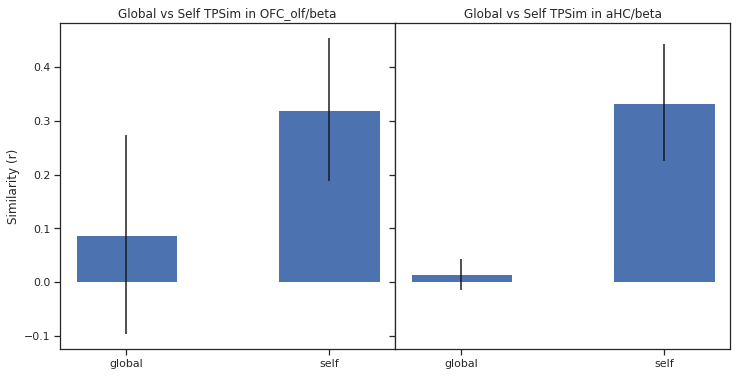

In [114]:
"""Upload all significant results by subjects and plot averages """
from os import listdir
import matplotlib.pyplot as plt

path = join(st.path, '_Figures_TPSim_paper/')

rois = ['OFC_olf','aHC']
conds = ['global','self']
files = listdir(path)

fig, axs = plt.subplots(1,2, figsize=(12, 6), facecolor='w', edgecolor='k',sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i,roi in enumerate(rois):   
    all_btw, all_wth = [], []
    for f in files:
        if f.endswith(roi+'.csv'):
            df = pd.read_csv(path+f)
            df_gr = df.groupby(['lab_tps']).mean()
            btw, wth = df_gr['tpsim'].values
            all_btw.append(btw), all_wth.append(wth)
    
    x = [np.mean(all_btw),np.mean(all_wth)]        
    sd = [np.std(all_btw),np.std(all_wth)]        
    
    axs[i].bar(np.arange(len(conds)), x, width=0.5, yerr=sd)
    axs[i].set_title('Global vs Self TPSim in '+roi+'/'+freq[2:])
    axs[0].set_ylabel('Similarity (r)')
    axs[i].set_xticks(np.arange(len(conds)))
    axs[i].set_xticklabels(conds)

#plt.show()
plt.savefig(path+'Plots_TPSim_Self.png')
plt.savefig(path+'Plots_TPSim_Self.pdf')